In [21]:
%matplotlib inline

import os
import datetime
import time
import json

import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.metrics import mean_squared_error,r2_score, roc_auc_score, roc_curve, auc
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

from scipy.sparse import csr_matrix, hstack

In [22]:
## daily prices

def preprbd(x_db):
    x_db.columns = [x.lower() for x in x_db.columns.values]
    ## x_db.drop(['date_text','month','month day','day','year'],axis=1,inplace=True)
    x_db.drop(['open','high','low','market cap'],axis=1,inplace=True)


bit_price_d = pd.read_excel("bitcoin_data/btc_close_daily.xlsx")
preprbd(bit_price_d)
bit_price_d.rename(columns={'close':'btc_close'},inplace=True)


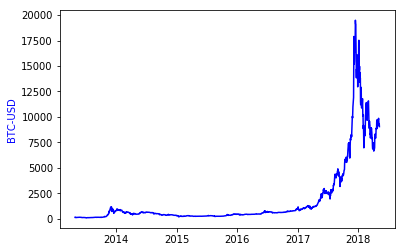

In [23]:
fig, ax1 = plt.subplots()

ax1.plot(bit_price_d['date'],bit_price_d['btc_close'],'b')
ax1.set_ylabel('BTC-USD',color='b')


plt.show()

#### Reading news

In [24]:
re.sub("([0-9]*),([0-9]*)","\\1\\2","ninth in terms of BTC/USD ($1,536,570) trading")

'ninth in terms of BTC/USD ($1536570) trading'

In [25]:
%%time

def clean_text(text):
    text = re.sub("<.*?>.*?</.*?>","",text)
    text = re.sub("&amp;","&",text)
    text = re.sub("\n"," ",text)
    text = re.sub("'","",text)
    text = re.sub("\$([0-9])","USD \\1",text)
    text = re.sub("([0-9])k","\\1 thousands",text)    
    text = re.sub("([0-9])m","\\1 million",text)
    text = re.sub("([0-9])bn","\\1 billion",text)
    text = re.sub("([0-9]*),([0-9]*)","\\1\\2",text)  ## removing thousands separator
    text = re.sub("R&D","RnD",text)

    return text
    

## Loading text
DIR_FILE = "news_forbes"
news_corpus = []
for i_file in os.listdir(DIR_FILE):
    
    # read file
    tt = open (DIR_FILE + "/"+i_file, encoding='utf-8', errors='ignore')


    # process headline
    news_headline = tt.readline()
    news_headline = re.sub("\n","",news_headline)
    news_headline = clean_text(news_headline)
    
    # now time for time
    news_time = tt.readline()
    news_time = datetime.datetime.strptime(news_time[0:10],"%Y-%m-%d")
    
    # news text and brief
    news_text = "".join(tt.readlines())
    news_text = clean_text(news_text)
    news_corpus.append([news_time,news_headline,news_text])
    
    
print ("text loaded")

news_corpus = pd.DataFrame(news_corpus)
news_corpus.columns = ['date_orig','headline','text']


## aggregate text and headlines on daily level
def compute_metrics(x):
    result = {'headline': " ".join(x['headline']), 'text': " ".join(x['text']),'count_news':len(x)}
    return pd.Series(result, name='metrics')

news_corpus = news_corpus.groupby('date_orig').apply(compute_metrics)



news_corpus.sort_index(inplace=True)
news_corpus.reset_index(inplace=True)


## MAKE DATE SHIFT
## current news predict next date price
# cd_news['date'] = [x + datetime.timedelta(days=0) for x in cd_news['date']]

print ("metrics computed")

news_corpus.head()

text loaded
metrics computed
Wall time: 7.74 s


In [50]:
pd.set_option('display.max_colwidth', -1)
aa = news_corpus.sample(1)
print (aa['text'])
pd.set_option('display.max_colwidth', 1)

528         Last year Blizzard cooperated with the FBI to get two Diablo III players to plead guilty in criminal court over charges relating to a series of in-game thefts in summer after the games release. Patrick Nepomuceno and Michael Stinger spent a summer using a Remote Access Tool sent as as link sent through Diablo IIIs chat system to take control of other players computers and transfer gold and Legendary items to their own accounts. Reporting on the case for Fusion Kashmir Hill recounts the duos plans to sell the stolen items through the games now defunct Auction House a contentious addition to the game that allowed players to sell each other gear and items in exchange for real money. Stinger contends Blizzard banned their accounts before either had a chance to actually make any money but estimates they had amassed around USD 9000 worth of items before they were caught. The pair eventually accepted misdemeanor plea offers for probation and promised to repay the USD 5654.61 Blizz

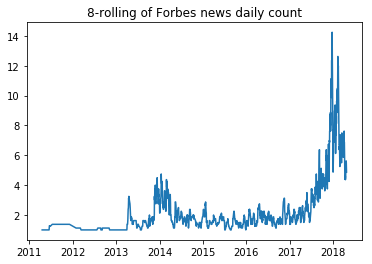

In [51]:
## Plot news count

fig, axs = plt.subplots()

aa = news_corpus.rolling(8,min_periods=1)['count_news'].mean()
axs.plot(news_corpus['date_orig'],aa)
axs.title.set_text("8-rolling of Forbes news daily count")
plt.show()


#### Explanation model

In [39]:
%%time

##  Get daily spot price
##
all_data = bit_price_d[['date','btc_close']].copy(deep=True)
all_data.sort_values('date',ascending=True,inplace=True)
all_data.reset_index(inplace=True)
all_data.drop('index',axis=1,inplace=True)


## make returns
price = all_data['btc_close']
price_l1 = all_data['btc_close'].shift(1)
all_data['btc_return'] = np.log(price) - np.log(price_l1)
all_data['btc_dir'] = (all_data['btc_return']>0) * 1 
all_data.dropna(inplace=True)


##  merge with news
row_filter = (all_data['date']>=np.min(news_corpus['date_orig'])) & (all_data['date']<=np.max(news_corpus['date_orig']))
all_data = all_data.loc[row_filter,:].copy(deep=True)


news_corpus['date'] = [x + datetime.timedelta(days=1) for x in news_corpus['date_orig']]

all_data = all_data.merge(news_corpus[['date','count_news','headline','text']],how='left',on='date')
all_data.fillna('',inplace=True)

filt = [x=='' for x in all_data['count_news']]
all_data.loc[filt,'count_news']=0


class LemmaTokenizer():
     def __init__(self):
        self.stm = SnowballStemmer('english')
        self.tkn = RegexpTokenizer(r'\w+')
     def __call__(self, doc):
         return [self.stm.stem(t) for t in self.tkn.tokenize(doc)]
         ##return [self.stm.stem(t) for t in word_tokenize(doc)]

## make headlines
##
tfidf = TfidfVectorizer(ngram_range=(1,2),min_df=5, tokenizer=LemmaTokenizer(),
                       stop_words='english')
tfidif_headline = tfidf.fit_transform(all_data['headline'])
tfidf_col_names = tfidf.get_feature_names() 
print (tfidif_headline.shape)
print ("headline processed")

tfidf = TfidfVectorizer(ngram_range=(1,2),min_df=10, tokenizer=LemmaTokenizer(),
                       stop_words='english')
tfidif_text = tfidf.fit_transform(all_data['text'])
tfidf_col_names += tfidf.get_feature_names()
print (tfidif_text.shape)
print ("text processed")


## add column with news counts
tfidif_vectors = hstack([csr_matrix(all_data[['count_news']].astype(float)),tfidif_headline,tfidif_text],format='csr')
tfidf_col_names = ['#var_count_news'] + tfidf_col_names

##tfidif_vectors = hstack([tfidif_headline,tfidif_text],format='csr')
## tfidif_vectors = tfidif_headline


print (tfidif_vectors.shape)
## tfidif_vectors
all_data

(1820, 1174)
headline processed
(1820, 22397)
text processed
(1820, 23572)
Wall time: 42.7 s


In [40]:
## split into test and train
##

train_size =0.95
train_ind = int(all_data.shape[0] * train_size)
print (all_data.loc[train_ind,'date'])


matr = tfidif_vectors

dates_train =all_data.loc[:train_ind,'date']
X_train = matr[:train_ind+1,]
y_train = all_data.loc[:train_ind,'btc_dir']

dates_test = all_data.loc[train_ind+1:,'date']
X_test = matr[train_ind+1:,]
y_test =  all_data.loc[train_ind+1:,'btc_dir']

2018-01-22 00:00:00


#### Ridge Model

In [41]:
def model_predict (mm,titles=[""]):
    
    print ("Fitting the model")
    ##mm.fit(X_train,y_train)
    
    y_pred = mm.predict(X_test)    

    ## Plot train data
    try: 
        y_score = mm.decision_function(X_test)
    except:
        y_score = mm.predict_proba(X_test)
        y_score = [x[1] for x in y_score]

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)    
    print ("ROC-AUC test: ", roc_auc) 
    
    
    fig, (axs) = plt.subplots(1,1, figsize=(5,5))
    axs.plot(fpr,tpr,'b', label="ROC_AUC: {0:.02f}".format(roc_auc))
    axs.plot([0, 1], [0, 1], color='navy', linestyle='--')
    axs.set_title(titles[0])
    axs.legend()
    plt.show()

In [52]:

def model_kfold_predict (mm, folds_num = 4, titles = ["",""]):
    roc_auc = []
    
    fig, (axs1, axs2) = plt.subplots(1,2, figsize=(15,7))
    axs1.plot([0, 1], [0, 1], color='navy', linestyle='--')
    axs2.plot([0, 1], [0, 1], color='navy', linestyle='--')

    kf = KFold (n_splits=folds_num,shuffle=False)
    tscv = TimeSeriesSplit(n_splits=folds_num)
    print ("Doing TimeSeries validation")    
        
    i = 0 
    for train_index, test_index in tscv.split(X_train):
        i=i+1
        print ("Doing fold " + str(i))
        
        X_fold_train, X__fold_test = X_train[train_index], X_train[test_index]
        y_fold_train, y__fold_test = y_train[train_index], y_train[test_index]

        mm.fit(X_fold_train, y_fold_train)
        
        try: 
            y_score = mm.decision_function(X__fold_test)
        except:
            y_score = mm.predict_proba(X__fold_test)
            y_score = [x[1] for x in y_score]
        
        fpr, tpr, _ = roc_curve(y__fold_test, y_score)
        a1 = auc(fpr, tpr)
        roc_auc.append(a1)
        axs1.plot(fpr,tpr, label="fold "+str(i)+" AUC = {0:.02f}".format(a1))
        
    print ("KFold ROC_AUC: ",["{0:.4f}".format(x) for x in roc_auc], np.mean(roc_auc))
    
    
    ## Do on test data
    mm.fit(X_train,y_train)
    ## Plot train data
    try: 
        y_score = mm.decision_function(X_test)
    except:
        y_score = mm.predict_proba(X_test)
        y_score = [x[1] for x in y_score]

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)    
    print ("ROC-AUC test: ", roc_auc) 

    axs2.plot(fpr,tpr,label="ROC_AUC: {0:.02f}".format(roc_auc))
    
    axs1.set_title (titles[0])
    axs2.set_title (titles[1])
    axs1.legend(loc=4)
    axs2.legend(loc=4)
    plt.show()

Doing TimeSeries validation
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 5
Doing fold 6
Doing fold 7
Doing fold 8
Doing fold 9
Doing fold 10
KFold ROC_AUC:  ['0.3874', '0.4404', '0.5256', '0.4122', '0.5095', '0.5905', '0.4589', '0.3627', '0.4773', '0.4734'] 0.463779875278
ROC-AUC test:  0.566551212271


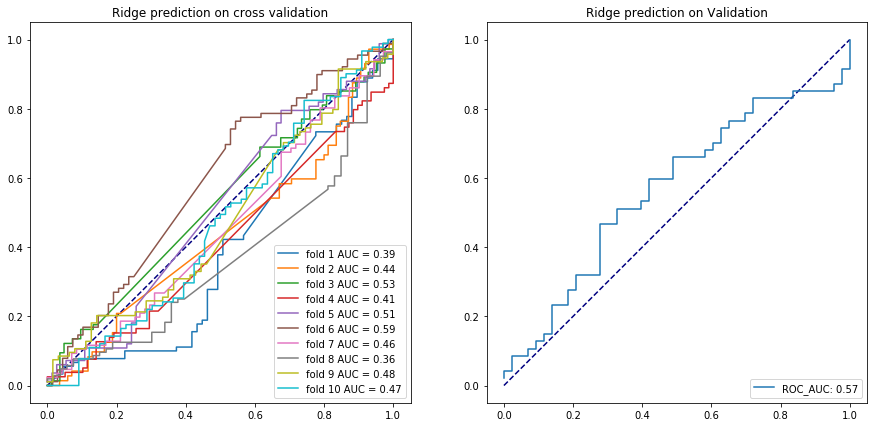

In [59]:
rdg = RidgeClassifier(alpha=1, fit_intercept=True, normalize=False)
model_kfold_predict(rdg,folds_num=10, titles=["Ridge prediction on cross validation","Ridge prediction on Validation"])

#### Extra Trees

In [54]:
%%time
kf = KFold (n_splits=4)

for i_tree in np.arange(10,20,10):
    etr = ExtraTreesRegressor(n_estimators=i_tree, criterion='mse', 
                               max_depth=None, min_samples_split=2, 
                               min_samples_leaf=1, n_jobs = -1, random_state=14)

    ##scores = cross_val_score(etr, X_train,y_train,cv=kf,scoring ='neg_mean_squared_error')
    ##print (i_tree, np.mean(scores), scores)

Wall time: 500 µs


In [55]:
%%time
etr  = ExtraTreesClassifier(n_estimators=50, criterion='gini', 
                           max_depth=None, min_samples_split=2, 
                           min_samples_leaf=5, n_jobs = -1, 
                           random_state=14, bootstrap = True, 
                           oob_score  = False)
etr.fit(X_train,y_train)

Wall time: 158 ms


Doing TimeSeries validation
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 5
Doing fold 6
Doing fold 7
Doing fold 8
Doing fold 9
Doing fold 10
KFold ROC_AUC:  ['0.5096', '0.4353', '0.4919', '0.5446', '0.4848', '0.5230', '0.5357', '0.5098', '0.5274', '0.5108'] 0.507282247621
ROC-AUC test:  0.538347352796


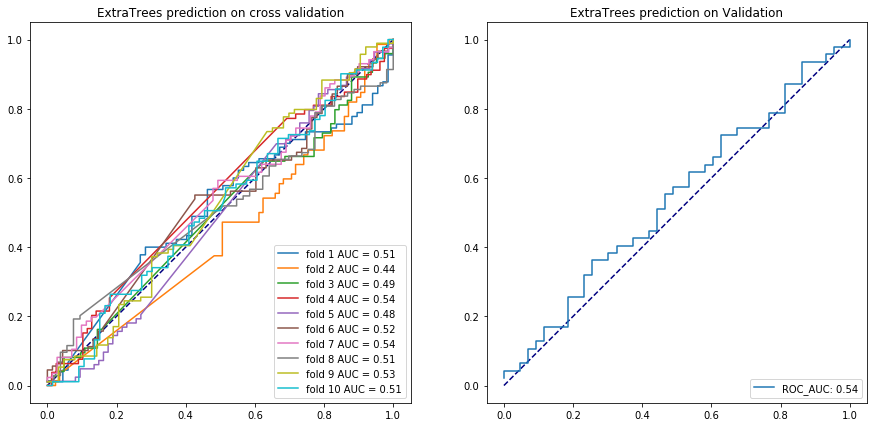

In [56]:
## model_kfold_predict(etr)
model_kfold_predict(etr,folds_num=10, titles=["ExtraTrees prediction on cross validation","ExtraTrees prediction on Validation"])

In [57]:
imp = etr.feature_importances_
ind = np.argsort(imp)
ind = ind[::-1]

for i_ind in ind[0:20]:
    feat = tfidf_col_names[i_ind]
    print (feat, imp[i_ind])


21 million 0.00485339739841
case 0.00264890860736
lost 0.00187942548586
1 6 0.00187811749892
need use 0.00185927179278
compris 0.00182927588044
late 2013 0.00180737902588
usd 300 0.00175789528386
becom 0.00162427688705
28 0.00159886002418
million 0.0015685405972
expand 0.00155928226961
100 percent 0.00154584751018
50 million 0.00152477960352
1 billion 0.00151678472734
power 0.00149782644857
24 0.00148206720486
georg 0.00147743680914
fleet 0.00145810932287
sign 0.00144402416619


Ridge MSE 0.00305
ExtraTrees MSE 0.00239


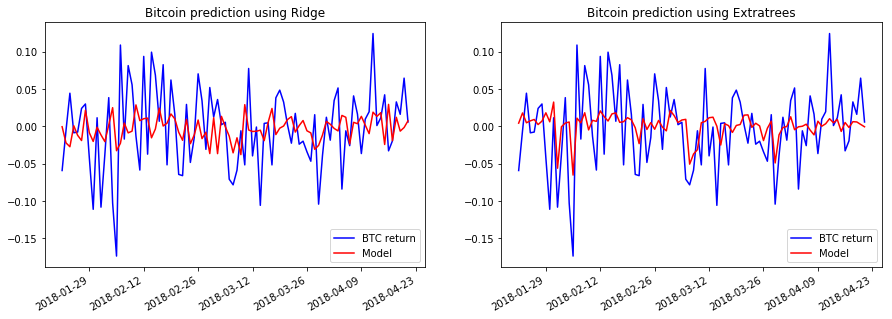

In [729]:
## Plot  data
fig, (axs,axs2) = plt.subplots(1,2, figsize=(15,5))

##fig2, (axs2) = plt.subplots()
y_pred = rdg.predict(X_test)
print ("Ridge MSE {0:.5f}".format(mean_squared_error(y_pred,y_test)))
axs.plot(dates_test,y_test,'b')
axs.plot(dates_test,y_pred,'r')
axs.set_title("Bitcoin prediction using Ridge")

axs.legend( ['BTC return', 'Model'])

y_pred = etr.predict(X_test)
print ("ExtraTrees MSE {0:.5f}".format(mean_squared_error(y_pred,y_test)))
axs2.plot(dates_test,y_test,'b')
axs2.plot(dates_test,y_pred,'r')
axs2.set_title("Bitcoin prediction using Extratrees")
axs2.legend( ['BTC return', 'Model'])
fig.autofmt_xdate()
plt.show()